# Listing 5.16 Instantiating the VGG16 convolutional base

In [2]:
import tensorflow as tf
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# Listing 5.17 Extracting features using the pretrained convolutional base

In [5]:
config = tf.compat.v1.ConfigProto()

config.gpu_options.allow_growth=True

sess = tf.compat.v1.Session(config=config)

In [6]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [7]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
sess = tf.compat.v1.Session(config=config)

In [8]:
tf.config.experimental.set_memory_growth = True
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
base_dir = './dog_cat1/abc'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))
test_features = np.reshape(test_features, (1000, 4*4* 512))

# Listing 5.18 Defining and training the densely connected classifier

In [10]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc'])
history = model.fit(train_features, train_labels,
epochs=30,
batch_size=20,
validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 18ms/step - loss: 0.6457 - acc: 0.6097 - val_loss: 0.4382 - val_acc: 0.8150
Epoch 2/30
100/100 [==============================] - 1s 5ms/step - loss: 0.4423 - acc: 0.7898 - val_loss: 0.3565 - val_acc: 0.8540
Epoch 3/30
100/100 [==============================] - 1s 5ms/step - loss: 0.3550 - acc: 0.8701 - val_loss: 0.3200 - val_acc: 0.8720
Epoch 4/30
100/100 [==============================] - 1s 5ms/step - loss: 0.3070 - acc: 0.8723 - val_loss: 0.2928 - val_acc: 0.8850
Epoch 5/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2872 - acc: 0.8843 - val_loss: 0.3145 - val_acc: 0.8500
Epoch 6/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2832 - acc: 0.8891 - val_loss: 0.2689 - val_acc: 0.8970
Epoch 7/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2515 - acc: 0.8974 - val_loss: 0.2588 - val_acc: 0.9000
Epoch 8/30
100/100 [==============================] - 0s 5ms/step - loss: 0

# Listing 5.19 Plotting the results

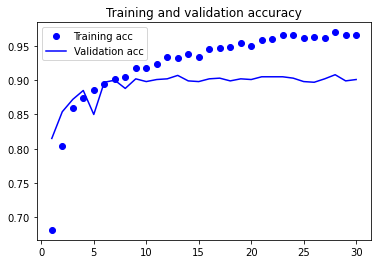

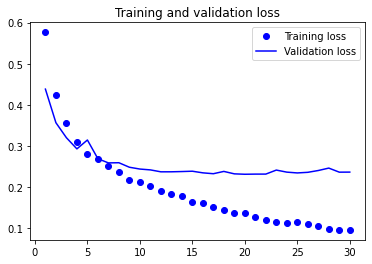

In [11]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Listing 5.20 Adding a densely connected classifier on top of the convolutional base

In [12]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [14]:
conv_base.trainable = False

In [15]:
 print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


# Listing 5.21 Training the model end to end with a frozen convolutional base

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 [==============================] - 15s 144ms/step - loss: 0.6450 - acc: 0.6321 - val_loss: 0.4662 - val_acc: 0.8080
Epoch 2/30
100/100 [==============================] - 16s 155ms/step - loss: 0.5096 - acc: 0.7553 - val_loss: 0.3798 - val_acc: 0.8530
Epoch 3/30
100/100 [==============================] - 16s 157ms/step - loss: 0.4595 - acc: 0.7900 - val_loss: 0.3534 - val_acc: 0.8610
Epoch 4/30
100/100 [==============================] - 15s 150ms/step - loss: 0.4279 - acc: 0.8110 - val_loss: 0.3120 - val_acc: 0.8790
Epoch 5/30
100/100 [==============================] - 15s 149ms/step - loss: 0.4015 - acc: 0.8266 - val_loss: 0.2970 - val_acc: 0.8930
Epoch 6/30
100/100 [==============================] - 15s 155ms/step - loss: 0.3746 - acc: 0.8517 - val_loss: 0.2849 - val_acc: 0.8920
Epoch 7/30
100/100 [==============================] - 15s 154ms/step - loss: 0.3605 - acc: 0.8480 - val_loss: 0.2751 - val_acc: 0.8960
Epoch 8/30
100/100 [==============================] - 1

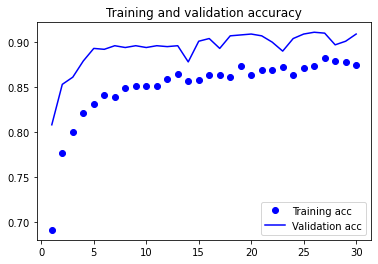

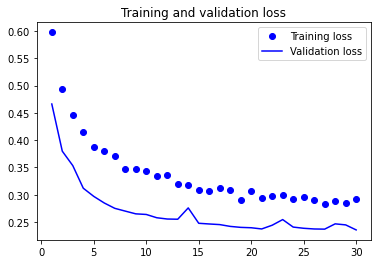

In [17]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# As a reminder, this is what your convolutional base looks like:

In [18]:
 conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# Listing 5.22 Freezing all layers up to a specific on

In [14]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Listing 5.23 Fine-tuning the model

In [15]:
model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['acc'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 153s 2s/step - loss: 0.2931 - acc: 0.8670 - val_loss: 0.2287 - val_acc: 0.9130
Epoch 2/100
100/100 [==============================] - 151s 2s/step - loss: 0.2494 - acc: 0.8860 - val_loss: 0.2425 - val_acc: 0.9050
Epoch 3/100
100/100 [==============================] - 153s 2s/step - loss: 0.2266 - acc: 0.9030 - val_loss: 0.1953 - val_acc: 0.9200
Epoch 4/100
100/100 [==============================] - 154s 2s/step - loss: 0.2281 - acc: 0.9055 - val_loss: 0.1944 - val_acc: 0.9220
Epoch 5/100
100/100 [==============================] - 156s 2s/step - loss: 0.2189 - acc: 0.9085 - val_loss: 0.2023 - val_acc: 0.9230
Epoch 6/100
100/100 [==============================] - 154s 2s/step - loss: 0.1841 - acc: 0.9240 - val_loss: 0.2068 - val_acc: 0.9190
Epoch 7/100
100/100 [==============================] - 154s 2s/step - loss: 0.1863 - acc: 0.9210 - val_loss: 0.1978 - val_acc: 0.9250
Epoch 8/100
100/100 [==============================] - 156s 2s

Epoch 62/100
100/100 [==============================] - 145s 1s/step - loss: 0.0373 - acc: 0.9880 - val_loss: 0.2944 - val_acc: 0.9350
Epoch 63/100
100/100 [==============================] - 145s 1s/step - loss: 0.0310 - acc: 0.9870 - val_loss: 0.2696 - val_acc: 0.9430
Epoch 64/100
100/100 [==============================] - 145s 1s/step - loss: 0.0261 - acc: 0.9915 - val_loss: 0.2607 - val_acc: 0.9370
Epoch 65/100
100/100 [==============================] - 145s 1s/step - loss: 0.0279 - acc: 0.9910 - val_loss: 0.2736 - val_acc: 0.9370
Epoch 66/100
100/100 [==============================] - 145s 1s/step - loss: 0.0275 - acc: 0.9875 - val_loss: 0.3915 - val_acc: 0.9130
Epoch 67/100
100/100 [==============================] - 3027s 30s/step - loss: 0.0313 - acc: 0.9870 - val_loss: 0.2684 - val_acc: 0.9330
Epoch 68/100
100/100 [==============================] - 148s 1s/step - loss: 0.0280 - acc: 0.9925 - val_loss: 0.2866 - val_acc: 0.9290
Epoch 69/100
100/100 [==============================]

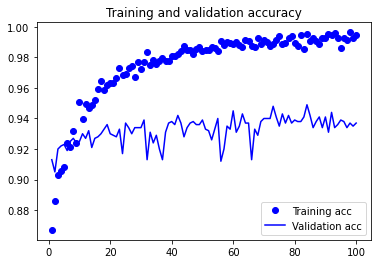

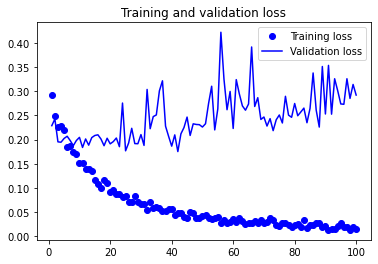

In [16]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Listing 5.24 Smoothing the plots

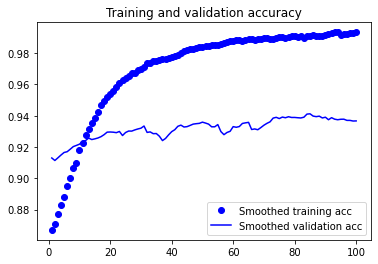

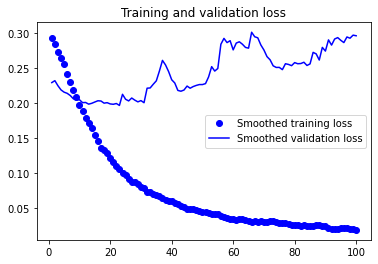

In [17]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
plt.plot(epochs,
    smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
    smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,
    smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
    smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

In [18]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
test acc: 0.9430000185966492
